## 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
"""
网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合
网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况
下面要做的事情：
1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动
2.考虑正则化或者假如droput层来防止过拟合
3.考虑数据预处理中采用数据标准化，让数据均匀分布
4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）
5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例
6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量
"""

'\n网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合\n网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况\n下面要做的事情：\n1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动\n2.考虑正则化或者假如droput层来防止过拟合\n3.考虑数据预处理中采用数据标准化，让数据均匀分布\n4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）\n5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例\n6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量\n'

## 2.加载数据

"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [4]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


In [5]:

#神经网络模型
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_output_channels, dropout):#加了 dropout
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(p=dropout)  # 添加dropout层

        self.conv7 = nn.Conv2d(64, num_output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # dropout层应用于卷积层之后

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.dropout5(x)

        x = self.conv6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.conv7(x)

        return x




## 3.加载模型

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载模型
model = torch.load('./model/model_origin_500_optuna_02.pth', map_location=device)# from torchsummary import summary
# # 将模型移动到适当的设备
model = model.to(device)


## 4.预测

In [68]:
# 设置模型为评估模式
model.eval()

# 输入数据进行预测
input_data =all_data[-10]  # 你的输入数据
print("all_data[0].shape:",input_data.shape)

#调整输入input的维度顺序,作为E，用于下面change_Label_to_a中(E-A)/(B-A)得到a值
matrix_64 = input_data.cpu()
matrix_64 = matrix_64.permute(1,2,0)  
print(matrix_64.shape)


# 转换为四维
input_data = input_data.unsqueeze(0)#用实际数据，数据格式为(1,2, 64, 64)，不能为2x64x64
# input_data = torch.randn(1,2, 64, 64)
print("input_data.shape:",input_data.shape)#input_data.shape: torch.Size([1, 2, 64, 64])
input_tensor = input_data.to(device)

with torch.no_grad():
    output = model(input_tensor)##如果报错的话需要把网络的设计加上，里面涉及model(input)

# 打印预测结果
# print(output)

all_data[0].shape: torch.Size([2, 64, 64])
torch.Size([64, 64, 2])
input_data.shape: torch.Size([1, 2, 64, 64])


In [67]:
matrix_64.numpy()

array([[[ 2.77683973e+00,  8.93238902e-01],
        [ 2.81415224e+00,  6.92741275e-01],
        [ 2.86211038e+00,  4.78969336e-01],
        [ 2.91796350e+00,  2.50687182e-01],
        [ 2.97846246e+00,  7.45594734e-03],
        [ 3.04323173e+00, -2.49907136e-01],
        [ 3.11667967e+00, -5.20385444e-01],
        [ 3.20609927e+00, -8.03360105e-01],
        [ 3.31223297e+00, -1.09486997e+00],
        [ 3.42564845e+00, -1.38403320e+00],
        [ 3.53650284e+00, -1.65749466e+00],
        [ 3.64935708e+00, -1.90891039e+00],
        [ 3.78014898e+00, -2.13900971e+00],
        [ 3.90074706e+00, -2.32451797e+00],
        [ 3.95439386e+00, -2.43063354e+00],
        [ 3.92809105e+00, -2.45528364e+00],
        [ 3.86232829e+00, -2.42783046e+00],
        [ 3.79664421e+00, -2.37274384e+00],
        [ 3.74398828e+00, -2.29813004e+00],
        [ 3.70392323e+00, -2.20580888e+00],
        [ 3.67365813e+00, -2.09718752e+00],
        [ 3.65188456e+00, -1.97433174e+00],
        [ 3.63902140e+00, -1.839

In [49]:
print(all_label[-10].numpy())


[[[ 2.76224995e+00  2.79293871e+00  2.83389115e+00  2.88520002e+00
    2.94344497e+00  3.00627136e+00  3.07503629e+00  3.15504241e+00
    3.25364137e+00  3.37030196e+00  3.48562074e+00  3.59064317e+00
    3.71066070e+00  3.85190868e+00  3.95558882e+00  3.96324992e+00
    3.90299821e+00  3.83000183e+00  3.76928258e+00  3.72359371e+00
    3.68938136e+00  3.66392875e+00  3.64676881e+00  3.63888931e+00
    3.64156055e+00  3.65552616e+00  3.68060565e+00  3.71558428e+00
    3.75827503e+00  3.80553246e+00  3.85309243e+00  3.89523625e+00
    3.92482257e+00  3.93426943e+00  3.91735435e+00  3.87062383e+00
    3.79361176e+00  3.68817258e+00  3.55772305e+00  3.40620756e+00
    3.23572874e+00  3.05097556e+00  2.88121748e+00  2.76484323e+00
    2.70738125e+00  2.68866944e+00  2.68358946e+00  2.66993380e+00
    2.65009928e+00  2.63028550e+00  2.60823011e+00  2.58082247e+00
    2.54706120e+00  2.51035118e+00  2.53496933e+00  2.69541931e+00
    2.87949491e+00  2.86410069e+00  2.81640053e+00  2.80872631

In [50]:
print(output.cpu().numpy())

[[[[ 2.23461676e+00  2.71345448e+00  2.75118065e+00  2.88989687e+00
     2.92320609e+00  2.99858928e+00  3.02852941e+00  3.00040340e+00
     3.06148481e+00  3.17591262e+00  3.30571318e+00  3.40916014e+00
     3.45675635e+00  3.46103787e+00  3.45352387e+00  3.44069910e+00
     3.40264940e+00  3.34434128e+00  3.27207899e+00  3.20472980e+00
     3.17312407e+00  3.17140102e+00  3.15313482e+00  3.10863113e+00
     3.06482315e+00  3.03773236e+00  3.02263618e+00  3.02918291e+00
     3.04840088e+00  3.08582497e+00  3.14338493e+00  3.19773531e+00
     3.23000646e+00  3.23428893e+00  3.21843767e+00  3.17542267e+00
     3.12386966e+00  3.07671285e+00  3.04017496e+00  3.01608491e+00
     3.00119925e+00  2.94128561e+00  2.82816672e+00  2.70073223e+00
     2.62200475e+00  2.57240486e+00  2.53836107e+00  2.51486087e+00
     2.50404572e+00  2.50027871e+00  2.50344825e+00  2.52230549e+00
     2.54709458e+00  2.55500555e+00  2.54744101e+00  2.55132484e+00
     2.57616758e+00  2.61939955e+00  2.66266727e

## 5.转换格式(label转为最终的weights)

In [18]:
#将label面心值转为a值
def change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers):
    a_vertical = np.zeros((64, 65, 2))
    # a_vertical = np.random((64, 65, 2))
    a_horizontal = np.zeros((64, 65, 2))
    # a_horizontal = np.random.random((64, 65, 2))


    # 21. 求a:   横着的边，分两种情况，边缘（对称的）和非边缘的边.这里matrix_64要行列互换，因为横着时面心值是一列一列求得，竖着时是一行一行求的。
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[i, 0]) / (matrix_64[i, 63] - matrix_64[i, 0])#换之前
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[0, i]) / (
                    matrix_64[63, i] - matrix_64[0, i])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[i, j]) / (matrix_64[i, j-1] - matrix_64[i, j])
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[j, i]) / (
                    matrix_64[j - 1, i] - matrix_64[j, i])

    # 22. 求a:   竖着的边，分两种情况，边缘（对称的）和非边缘的边
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                a_vertical[i, j] = (all_vertical_edge_centers[i, 0] - matrix_64[i, 0]) / (
                    matrix_64[i, 63] - matrix_64[i, 0])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # 2.错误matrix_64[i, j-1]) / (改成matrix_64[i, j]) / (
                a_vertical[i, j] = (all_vertical_edge_centers[i, j] - matrix_64[i, j]) / (
                    matrix_64[i, j - 1] - matrix_64[i, j])

    # # 若最终a对应的矩阵里面出现无穷，则将其替换为0.5.解决了分母为0的问题
    # a_vertical[np.isinf(a_vertical)] = 0.5
    # a_horizontal[np.isinf(a_horizontal)] = 0.5
    #这里64x65x2截成64x64x2,因为边框对称时值相同
    
    a_vertical = torch.tensor(a_vertical[:,:64,:])
    a_horizontal = torch.tensor(a_horizontal[:,:64,:])

    print(a_vertical.shape)
    print(a_horizontal.shape)
    
    return  a_vertical,a_horizontal

In [71]:
#返回一个列表，里面嵌套两个子列表，第一个子列表存放的是内部的a值，第二个子列表存放的是边框的a值，
#且顺序为上（左到右），下（左到右），左（下到上），右（下到上）
def conversion_format(output):
    # 调整output的维度顺序
    output = output.permute(0,2,3,1)  #torch.Size([1, 64, 64, 4])
    print(output.shape)
    output = output[0]#torch.Size([64, 64, 4])
    print(output.shape)
    # print(output)

    #将输出output拆成两个面心值
    all_vertical_edge_centers = output[:, :, 0:2].cpu()
    all_horizontal_edge_centers = output[:, :, 2:4].cpu()
#     print(all_vertical_edge_centers.shape)
#     print(all_horizontal_edge_centers.shape)

    
    a_vertical,a_horizontal  = change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers)    
    
    # 将前两个元素相加除以二得到一个元素(x+y/)2
    avg_vertical = (a_vertical[:, :, 0] + a_vertical[:, :, 1]) / 2
    # 将后两个元素相加除以二得到另一个元素
    avg_horizontal = (a_horizontal[:, :, 0] + a_horizontal[:, :, 1]) / 2

    # 重新组合成新的形状为(64, 64, 2)的张量
    new_avg_a_output = torch.stack([avg_vertical, avg_horizontal], dim=2)
    # 打印转换后的数据形状
#     print(new_avg_a_output.shape)

    #返回两个求完平均的面心值,包括两个64*64矩阵，矩阵是求完平均后的a值，一个竖着的，一个横着的
    vertical_1d = new_avg_a_output[:, :, 0]
    horizontal_1d = new_avg_a_output[:, :,1]
#     print(vertical_1d.shape)
#     print(horizontal_1d.shape)
    
    
    border = []#存所有边框，四个边框
    left_border=[]#存左边框
    bottom_border = []#存下边框
    inner = []#存内部的面心值

    #下面将2个64x64面心值变换格式，返回指定的格式result
    for i in range(len(vertical_1d)): #两个for循环等价于for i in range(64):
        for j in range(len(vertical_1d[i])):
            if j ==0:#j=0添加边框
                #添加左边框
                left_border.append(vertical_1d[i][0])
                #添加下边框
                bottom_border.append(horizontal_1d[i][0])
            else: 
                if i !=  63:#当竖着的最后一行时，上面没有对应的横着的
                    inner.append(vertical_1d[i][j])#竖着的
    #                 print("{j-1},{i+1}",j-1,i+1)
                    inner.append(horizontal_1d[j-1][i+1])   #再横着的   
                    if j == 63:#如果j=63的话，还需要再加入最后一列的横着的边
                        inner.append(horizontal_1d[63][i+1])#当i=63,横着的加最后一列 
                else:#if i ==63 :
                    inner.append(vertical_1d[63][j])#当i=63,inner最后添加竖着的一行竖线

    inner = [tensor.cpu().numpy().tolist() for tensor in inner]#将一维列表里面的tensor元素转为numpy格式，并返回cpu版本
    # print(inner)
    four_border = [bottom_border,bottom_border,left_border,left_border]#顺序是上（左到右），下（左到右），左（下到上），右（下到上）
    border = [item.numpy().tolist() for sublist in four_border for item in sublist]
    result = [inner,border]
    print(len(result))
    return result,a_vertical,a_horizontal,all_vertical_edge_centers,all_horizontal_edge_centers



In [72]:
# result  = conversion_format(output)
result,a_vertical,a_horizontal,all_vertical_edge_centers,all_horizontal_edge_centers  = conversion_format(output)

torch.Size([1, 64, 64, 4])
torch.Size([64, 64, 4])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
2


In [73]:
print(a_vertical.numpy())


[[[ 2.03377457e+01 -1.66442668e+00]
  [ 2.69876671e+00 -5.55036724e-01]
  [ 2.31305337e+00 -3.44710231e-01]
  [ 5.02507865e-01 -2.76196122e-01]
  [ 9.13344204e-01 -4.64815535e-02]
  [ 6.89253569e-01 -1.41335502e-01]
  [ 1.20017338e+00 -2.35067397e-01]
  [ 2.30034423e+00 -3.21033239e-01]
  [ 2.36256862e+00 -1.86916292e-01]
  [ 2.20195556e+00  4.42874283e-02]
  [ 2.08191729e+00  2.30737582e-01]
  [ 2.12838197e+00  2.54697412e-01]
  [ 2.47257376e+00  2.99469549e-02]
  [ 3.64607120e+00 -3.15418243e-01]
  [ 9.33643723e+00 -9.61490154e-01]
  [-1.85300312e+01 -4.51323128e+00]
  [-6.98995733e+00  4.48008204e+00]
  [-6.88603592e+00  2.59686208e+00]
  [-8.96212864e+00  2.48069525e+00]
  [-1.24595737e+01  2.63389826e+00]
  [-1.65383282e+01  2.20357943e+00]
  [-2.20672760e+01  1.53997087e+00]
  [-3.77735023e+01  1.11863923e+00]
  [-1.90200516e+02  1.11584437e+00]
  [ 6.98062210e+01  1.03889096e+00]
  [ 3.19276028e+01  8.83267462e-01]
  [ 2.22467918e+01  7.76678681e-01]
  [ 1.80404758e+01  7.481912

In [74]:
print(a_horizontal.numpy())

[[[ 1.56174242e+00  3.21170568e+00]
  [-6.73007488e-01  1.95209181e+00]
  [ 1.33748740e-01 -2.21453972e+01]
  [ 4.88142157e+00 -1.51750479e+01]
  [ 5.64360857e+00  4.86174707e+03]
  [ 1.38016089e+03 -8.44434071e+00]
  [-3.46810079e+00  2.84987092e+00]
  [-5.78468132e+00  9.25114822e+00]
  [-7.69629049e+00 -2.85525146e+02]
  [-1.40919666e+01 -5.28303337e+00]
  [-2.67600479e+01 -1.75724459e+00]
  [-3.22326431e+01  2.84652740e-01]
  [-2.17004261e+01  2.33192730e+00]
  [-1.52104445e+01  4.41405010e+00]
  [-1.36492720e+01  6.98522711e+00]
  [-1.57752056e+01  1.51227970e+01]
  [-2.07875156e+01 -9.28555222e+01]
  [-2.35719757e+01 -1.34009562e+01]
  [-1.90271130e+01 -8.90208435e+00]
  [-1.16091204e+01 -9.51948071e+00]
  [-6.48863363e+00 -1.61814041e+01]
  [-4.46880579e+00 -1.09747725e+01]
  [-4.72631741e+00 -2.76992679e+00]
  [-4.40770578e+00 -9.23450530e-01]
  [-1.62039685e+00  4.87878370e+00]
  [-4.10669118e-01  1.10448754e+00]
  [ 1.57250986e-01  2.61093140e+00]
  [ 9.56476152e-01  8.547607

In [76]:
all_vertical_edge_centers.numpy()

array([[[ 2.23461676e+00,  5.81320405e-01],
        [ 2.71345448e+00,  5.81457734e-01],
        [ 2.75118065e+00,  4.05279964e-01],
        [ 2.88989687e+00,  1.87636539e-01],
        [ 2.92320609e+00, -3.84981837e-03],
        [ 2.99858928e+00, -2.86281675e-01],
        [ 3.02852941e+00, -5.83966076e-01],
        [ 3.00040340e+00, -8.94204378e-01],
        [ 3.06148481e+00, -1.14935791e+00],
        [ 3.17591262e+00, -1.37122691e+00],
        [ 3.30571318e+00, -1.59439683e+00],
        [ 3.40916014e+00, -1.84487545e+00],
        [ 3.45675635e+00, -2.13211894e+00],
        [ 3.46103787e+00, -2.38303065e+00],
        [ 3.45352387e+00, -2.53266263e+00],
        [ 3.44069910e+00, -2.56653523e+00],
        [ 3.40264940e+00, -2.55082297e+00],
        [ 3.34434128e+00, -2.51579618e+00],
        [ 3.27207899e+00, -2.48322415e+00],
        [ 3.20472980e+00, -2.44897342e+00],
        [ 3.17312407e+00, -2.33654332e+00],
        [ 3.17140102e+00, -2.16352606e+00],
        [ 3.15313482e+00, -1.990

In [77]:
all_vertical_edge_centers.numpy()

array([[[ 2.23461676e+00,  5.81320405e-01],
        [ 2.71345448e+00,  5.81457734e-01],
        [ 2.75118065e+00,  4.05279964e-01],
        [ 2.88989687e+00,  1.87636539e-01],
        [ 2.92320609e+00, -3.84981837e-03],
        [ 2.99858928e+00, -2.86281675e-01],
        [ 3.02852941e+00, -5.83966076e-01],
        [ 3.00040340e+00, -8.94204378e-01],
        [ 3.06148481e+00, -1.14935791e+00],
        [ 3.17591262e+00, -1.37122691e+00],
        [ 3.30571318e+00, -1.59439683e+00],
        [ 3.40916014e+00, -1.84487545e+00],
        [ 3.45675635e+00, -2.13211894e+00],
        [ 3.46103787e+00, -2.38303065e+00],
        [ 3.45352387e+00, -2.53266263e+00],
        [ 3.44069910e+00, -2.56653523e+00],
        [ 3.40264940e+00, -2.55082297e+00],
        [ 3.34434128e+00, -2.51579618e+00],
        [ 3.27207899e+00, -2.48322415e+00],
        [ 3.20472980e+00, -2.44897342e+00],
        [ 3.17312407e+00, -2.33654332e+00],
        [ 3.17140102e+00, -2.16352606e+00],
        [ 3.15313482e+00, -1.990

In [21]:
print(len(result[0]))
print(len(result[1]))
print(8064+64*2)

8064
256
8192


In [22]:
result

[[1.0718649923801422,
  0.6395421624183655,
  0.9841715693473816,
  -2.8120211362838745,
  0.11315587162971497,
  -5.106722950935364,
  0.4334313254803419,
  -0.03637361526489258,
  0.27395903319120407,
  1.7424407005310059,
  0.48255299031734467,
  3.7899367809295654,
  0.9896554946899414,
  3.725754737854004,
  1.0878261625766754,
  16.09957766532898,
  1.1231214925646782,
  17.416736602783203,
  1.1563274338841438,
  18.810457229614258,
  1.191539689898491,
  18.08212375640869,
  1.2512603560462594,
  17.255480766296387,
  1.665326476097107,
  37.743359088897705,
  4.18747353553772,
  40.988097190856934,
  -11.521631240844727,
  -16.901344299316406,
  -1.2549376487731934,
  -11.04831314086914,
  -2.14458692073822,
  -10.644480228424072,
  -3.2407166957855225,
  -11.793488025665283,
  -4.912837743759155,
  -12.845460176467896,
  -7.1673743724823,
  -13.339756727218628,
  -10.263652563095093,
  -13.476074695587158,
  -18.327431559562683,
  -15.851726770401001,
  -94.54233568906784,
  

In [23]:
count = sum(1 for num in result[0] if 0 < num < 1)
print(count)
print(count/len(result[0]))

1078
0.13368055555555555


In [42]:
train_loss,test_loss = np.load('./data/lossa/loss_model_500_optuna_02.npy')
print(train_loss)
print(test_loss)

[1348.39619946 1258.3129878  1231.79749036 1222.09079576 1214.46762013
 1208.49125814 1203.09289384 1198.00090468 1194.16773033 1190.35706139
 1186.6247288  1183.49182713 1180.50412989 1178.20887327 1176.09618592
 1173.33254063 1171.67136681 1169.17366099 1167.65818572 1166.41954279
 1164.05178106 1162.58882856 1161.59459782 1160.40110576 1159.62648404
 1157.84488964 1156.30732167 1155.71771181 1154.78934979 1154.09580505
 1153.15663934 1152.42858756 1151.38879693 1150.86570299 1150.46341133
 1149.73256588 1149.24240315 1148.58431768 1147.46833909 1147.25061536
 1146.27864254 1146.29410863 1145.84190619 1145.38698339 1144.67323959
 1144.05305362 1143.72610736 1142.93880475 1142.84982812 1142.3697499
 1142.25182343 1141.66149235 1141.52368093 1140.8642807  1140.37250924
 1140.31697607 1140.34229732 1139.78177607 1139.20081019 1138.55562747
 1138.37518084 1138.32386959 1138.04625928 1137.59107184 1137.2086935
 1137.13340247 1136.8532275  1136.80181646 1136.59956241 1136.17125273
 1135.97

[0.00878, 0.00819, 0.00801, 0.00796, 0.0079, 0.00786, 0.00783, 0.0078, 0.00777, 0.00775, 0.00772, 0.0077, 0.00768, 0.00767, 0.00766, 0.00764, 0.00762, 0.00761, 0.0076, 0.00759, 0.00758, 0.00757, 0.00756, 0.00755, 0.00755, 0.00753, 0.00753, 0.00752, 0.00751, 0.00751, 0.00751, 0.0075, 0.00749, 0.00749, 0.00749, 0.00748, 0.00748, 0.00747, 0.00747, 0.00747, 0.00746, 0.00746, 0.00745, 0.00745, 0.00745, 0.00745, 0.00744, 0.00743, 0.00743, 0.00743, 0.00743, 0.00743, 0.00743, 0.00742, 0.00742, 0.00742, 0.00742, 0.00742, 0.00742, 0.00741, 0.00741, 0.00741, 0.00741, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.00739, 0.00739, 0.00739, 0.00739, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00738, 0.00737, 0.00737, 0.00738, 0.00737, 0.00737, 0.00737, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00736, 0.00735, 0.00735, 0.00735, 0.00735, 0.00735, 0.00735, 0.00735, 0.00734, 0.0

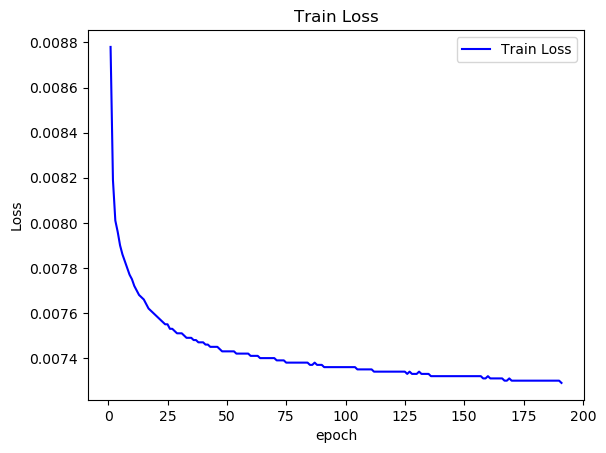

In [40]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.8), 5) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[0.00839, 0.00807, 0.00799, 0.00794, 0.00786, 0.00784, 0.00781, 0.00779, 0.00776, 0.00773, 0.00771, 0.00771, 0.00768, 0.00771, 0.00766, 0.00763, 0.00763, 0.00763, 0.0076, 0.0076, 0.00758, 0.00755, 0.0076, 0.00755, 0.00755, 0.00755, 0.00753, 0.00753, 0.00758, 0.00753, 0.00753, 0.0075, 0.0075, 0.0075, 0.00753, 0.0075, 0.0075, 0.0075, 0.00747, 0.0075, 0.00747, 0.00747, 0.00745, 0.00747, 0.00745, 0.00745, 0.00747, 0.00747, 0.00745, 0.00745, 0.0075, 0.00745, 0.00745, 0.00745, 0.00745, 0.00745, 0.00742, 0.00742, 0.00742, 0.00742, 0.00745, 0.00742, 0.00745, 0.00742, 0.00742, 0.00742, 0.00745, 0.0074, 0.00742, 0.0074, 0.0074, 0.0074, 0.0074, 0.00742, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.0074, 0.00742, 0.0074, 0.00742, 0.0074, 0.00737, 0.0074, 0.0074, 0.00737, 0.0074, 0.00737, 0.0074, 0.00737, 0.00737, 0.00737, 0.00737, 0.0074, 0.00737, 0.0074, 0.00737, 0.00737, 0.00737, 0.00737, 0.0074, 0.0074, 0.00737, 0.00737, 0.0074, 0.0074, 0.00734, 0.0074, 0.00737, 0.00737, 0.00737, 0.00737, 0.00734,

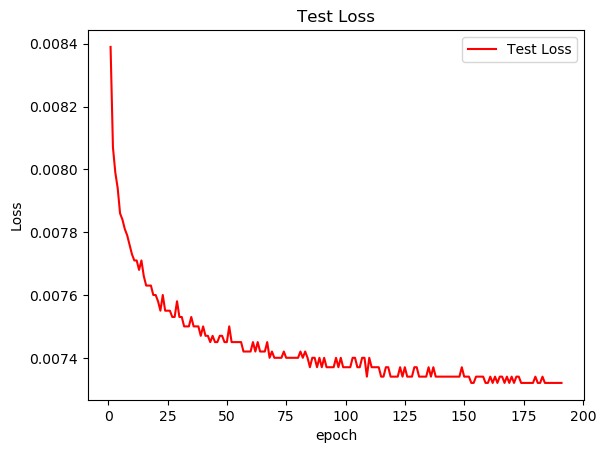

In [41]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)
test_loss = [round(int(a)/(all_data.shape[0]*0.2), 5) for a in test_loss]
print(test_loss)


# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()